## Instalación de dependencias y configuración del entorno

Instalamos todas las librerías necesarias para el procesamiento de datos, entrenamiento y evaluación de modelos de lenguaje. Incluye utilidades para embeddings semánticos, visualización, PyTorch con soporte CUDA y el ecosistema completo de Hugging Face, además de TRL desde GitHub para asegurar compatibilidad con configuraciones avanzadas de fine-tuning.

In [1]:
# Utilities required for dataset handling, semantic embeddings, and visualization
%pip install sentence_transformers datasets matplotlib seaborn tf-keras

# Core deep learning stack (PyTorch with CUDA support on Colab)
%pip install torch torchvision torchaudio

# Hugging Face ecosystem for model loading, training, and quantization
%pip install -U transformers accelerate peft bitsandbytes

# helpers
%pip install wordcloud

# TRL from GitHub to ensure compatibility with the latest SFTConfig features
%pip install git+https://github.com/huggingface/trl.git


  Using cached tf_keras-2.20.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow-2.20.0-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-2.0.1-cp313-cp313-manylinux1_x86_64.manylinux_2_28_x86_64.manylinux_2_5_x86_64.whl.metadata (9.0 kB)
  Using cached grpcio-1.76.0-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.7 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.0-py3-none-an

## Configuración del entorno de ejecución (GPU y Accelerate)

Establecemos variables de entorno para controlar el uso de GPU y evitar problemas comunes al entrenar modelos en notebooks. En particular, se fuerza el uso de una única GPU y se desactiva el mixed precision de Accelerate para mejorar la estabilidad del entrenamiento en este entorno.

In [2]:
import os

# Restrict execution to a single GPU to avoid DataParallel-related issues in notebooks
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Disable Accelerate mixed precision for improved stability in this environment
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"


## Configuración interactiva del chat

Ahora subimos el archivo de chat, el autor objetivo y el nombre del bot. Esta configuración es obligatoria y debe ejecutarse antes de continuar con el notebook.


In [3]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

uploader = widgets.FileUpload(
    accept=".txt",
    multiple=False,
    description="Subir chat (.txt)"
)

author_input = widgets.Text(
    description="Autor:",
    placeholder="Exactamente como aparece en el chat",
    layout=widgets.Layout(width="60%")
)

bot_input = widgets.Text(
    description="Bot:",
    placeholder="Nombre del bot (ej: MELINA)",
    layout=widgets.Layout(width="60%")
)

apply_button = widgets.Button(
    description="Aplicar configuración",
    button_style="primary"
)

out = widgets.Output()

def on_apply_clicked(_):
    with out:
        clear_output()

        if len(uploader.value) == 0:
            print("Por favor, subí un archivo .txt del chat.")
            return

        author = author_input.value.strip()
        bot = bot_input.value.strip()

        if not author:
            print("Ingresá el autor exactamente como aparece en el chat.")
            return
        if not bot:
            print("Ingresá un nombre para el bot.")
            return

        upload_info = uploader.value[0]
        content = bytes(upload_info["content"]).decode("utf-8-sig", errors="replace")

        global chat_file, target_author, bot_name, OUTPUT_DIR

        chat_file = "uploaded_chat.txt"
        with open(chat_file, "w", encoding="utf-8") as f:
            f.write(content)

        target_author = author
        bot_name = bot
        OUTPUT_DIR = "./chatbot_" + bot_name
        os.makedirs(OUTPUT_DIR, exist_ok=True)

        print("Configuración aplicada correctamente")
        print("chat_file:", chat_file)
        print("target_author:", target_author)
        print("bot_name:", bot_name)
        print("OUTPUT_DIR:", OUTPUT_DIR)

apply_button.on_click(on_apply_clicked)

display(
    widgets.VBox([
        widgets.HTML("<b>Configuración interactiva del chat</b>"),
        uploader,
        author_input,
        bot_input,
        apply_button,
        out
    ])
)


## Constantes globales del experimento

Definimos las constantes fijas del experimento y validamos que la configuración interactiva haya sido ejecutada correctamente.

In [4]:
# Fixed model identifier
MODEL_ID = "HuggingFaceTB/SmolLM3-3B"

# Special token used to separate consecutive messages
MSG_SEP = "<|msg_sep|>"

# Safety check: interactive configuration must be executed
required_vars = ["chat_file", "target_author", "bot_name", "OUTPUT_DIR"]
missing = [v for v in required_vars if v not in globals()]

if missing:
    raise RuntimeError(
        "Falta ejecutar la configuración interactiva. "
        f"Variables no definidas: {missing}"
    )

print("Constantes globales cargadas correctamente")
print("Modelo:", MODEL_ID)
print("Autor objetivo:", target_author)
print("Bot:", bot_name)
print("Directorio de salida:", OUTPUT_DIR)

Constantes globales cargadas correctamente
Modelo: HuggingFaceTB/SmolLM3-3B
Autor objetivo: Nico Bazan
Bot: NicoBotSmol
Directorio de salida: ./chatbot_NicoBotSmol


## Importación de librerías

Cargamos todas las dependencias necesarias para el procesamiento del chat, construcción del dataset, entrenamiento (Transformers/TRL), cuantización (bitsandbytes), LoRA (PEFT), evaluación y visualización.

In [5]:
import re
import random
import pandas as pd
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from trl import SFTTrainer, SFTConfig
from datasets import Dataset, load_dataset, DatasetDict
from sentence_transformers import SentenceTransformer, util
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import csv
import math
import gc
from tqdm import tqdm
from datetime import datetime, timedelta

print("done")
print(f"number of GPUs: {torch.cuda.device_count()}")
print(torch.__version__)

2025-12-20 01:35:06.279445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt

done
number of GPUs: 1
2.7.1+cu118


## Configuración del dispositivo de ejecución

Establecemos el dispositivo de cómputo a utilizar durante el entrenamiento y la inferencia. Utilizamos la GPU si está disponible, de lo contrario el código se ejecuta en CPU.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

Dispositivo: cuda


## Parámetros de filtrado y mensajes irrelevantes

Definimos el conjunto de patrones que identifican mensajes automáticos o irrelevantes generados por WhatsApp (por ejemplo, avisos del sistema o contenido multimedia omitido). Estos patrones se utilizan para filtrar el chat antes de construir los ejemplos de entrenamiento.

In [9]:
irrelevantData = {
    # Spanish system messages
    'eliminaste este mensaje',
    'se eliminó este mensaje',
    '<multimedia omitido>',
    'multimedia omitido',
    'los mensajes y las llamadas están cifrados de extremo a extremo',
    # English system messages
    'you deleted this message',
    'this message was deleted',
    '<media omitted>',
    'media omitted',
    'messages and calls are end-to-end encrypted',
}

def containsIrrelevantData(message: str) -> bool:
    """
    Assumes the input message is already lowercased.
    Returns True if the message contains any known WhatsApp system or noise pattern.
    """
    msg = message.lower()
    return any(irr in msg for irr in irrelevantData)


## Tokenizer del modelo

Cargamos el tokenizer asociado al modelo base. Se utiliza durante el preprocesamiento para convertir el historial de conversación al formato exacto requerido por el chat template del modelo.

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

## Procesamiento del chat de WhatsApp y formateo para el modelo

Convertimos el chat exportado de WhatsApp en ejemplos de entrenamiento listos para fine-tuning. Se agrupan mensajes consecutivos por autor, se construye un historial acotado por k_history y time_gap, y finalmente se serializa cada ejemplo usando el chat_template del tokenizer.

In [10]:
def clean_text(text: str) -> str:
    """
    Light text cleaning: lowercasing, whitespace normalization, and basic character filtering.
    Noise filtering (WhatsApp system messages) is handled by `containsIrrelevantData`.
    """
    text = text.lower().strip()
    text = re.sub(r"[^a-záéíóúñü0-9,.;:¡!¿?\s']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def parse_datetime(line: str):
    """Extracts WhatsApp timestamp if present; returns datetime or None."""
    match = re.match(r"(\d+/\d+/\d+[, ]\s?\d+:\d+)\s-", line)
    if match:
        for fmt in ("%d/%m/%y %H:%M", "%d/%m/%Y %H:%M"):
            try:
                return datetime.strptime(match.group(1).replace(",", ""), fmt)
            except:
                pass
    return None


def group_consecutive_messages(messages):
    """
    Groups consecutive messages from the same author into a single turn if they are close in time.
    Multiple messages within the same turn are joined using MSG_SEP.
    """
    grouped = []
    for author, msg, ts in messages:
        if (
            grouped
            and grouped[-1][0] == author
            and ts and grouped[-1][2]
            and (ts - grouped[-1][2]) < timedelta(hours=1)
        ):
            # Same author within the time window -> merge into the previous turn
            prev_msg = grouped[-1][1]
            new_msg = prev_msg + f" {MSG_SEP} " + msg
            grouped[-1] = (author, new_msg, ts)
        else:
            grouped.append((author, msg, ts))
    return grouped


def process_whatsapp_chat_with_roles(
    filepath,
    k_history=4,
    time_gap=timedelta(hours=3),
):
    """
    Builds training samples from a WhatsApp export:
      - Turns are consecutive messages from the same author (grouped)
      - A backward context window is built using k_history and time_gap
      - Roles follow the standard chat format: user / assistant
      - The final text is serialized using tokenizer.apply_chat_template(...)
    """
    print("Procesando chat (k-turns con roles)...")

    messages = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            ts = parse_datetime(line)
            match = re.match(r'\d+/\d+/\d+[, ]\s?\d+:\d+\s-\s([^:]+):\s(.+)', line)
            if match:
                author = match.group(1).strip()
                raw_msg = match.group(2)
                msg = clean_text(raw_msg)
                # Skip empty messages and WhatsApp system/noise lines
                if msg and not containsIrrelevantData(msg):
                    messages.append((author, msg, ts))

    if not messages:
        print("No se encontraron mensajes válidos.")
        return [], []

    messages = group_consecutive_messages(messages)
    print(f"Total turnos agrupados: {len(messages)}")

    prompts, responses = [], []
    formatted_data = []

    for i in range(1, len(messages)):
        author_i, msg_i, ts_i = messages[i]

        # Only keep samples where the target author is the assistant
        if author_i != target_author:
            continue

        conversation_history = [
            {
                "role": "system",
                "content": (
                    f"Eres {bot_name}, un bot de {target_author}, que se encarga de mantener "
                    f"conversaciones casuales. Respondes con la misma personalidad que {target_author} "
                    f"tiene en los chats de WhatsApp./no_think"
                ),
            }
        ]

        temp_history = []
        last_ts = ts_i

        for j in range(i - 1, -1, -1):
            a_j, m_j, ts_j = messages[j]
            if ts_j and last_ts and (last_ts - ts_j) > time_gap:
                break

            # Map WhatsApp authors to standard chat roles
            role = "assistant" if a_j == target_author else "user"
            temp_history.insert(0, {"role": role, "content": m_j})

            last_ts = ts_j if ts_j is not None else last_ts
            if len(temp_history) >= k_history:
                break

        if not temp_history:
            continue

        conversation_history.extend(temp_history)
        conversation_history.append({"role": "assistant", "content": msg_i})

        # Serialize messages into the exact format required by the model's chat template
        final_text = tokenizer.apply_chat_template(
            conversation_history,
            tokenize=False,
            enable_thinking=False,
        )

        formatted_data.append(final_text)

    print(f"Se generaron {len(formatted_data)} ejemplos de entrenamiento.")
    return formatted_data


formatted_data = process_whatsapp_chat_with_roles(chat_file)
df = pd.DataFrame({"text": formatted_data})
df.to_json(
    f"{OUTPUT_DIR}/formatted_data.jsonl",
    orient="records",
    lines=True,
    force_ascii=False,
)
print(f"Archivo guardado en: {OUTPUT_DIR}/formatted_data.jsonl")

Procesando chat (k-turns con roles)...
Total turnos agrupados: 33471
Se generaron 14797 ejemplos de entrenamiento.
Archivo guardado en: ./chatbot_NicoBotSmol/formatted_data.jsonl


## Preparación y partición del dataset

Aplicamos un filtrado mínimo para eliminar entradas vacías o ruidosas (incluyendo URLs), y convertimos el resultado a un Dataset de Hugging Face. Finalmente, dividimos el conjunto en entrenamiento y validación.

In [11]:
data = pd.read_json(f"{OUTPUT_DIR}/formatted_data.jsonl", lines=True)

# Basic cleanup: drop empty or extremely short samples
data = data[data["text"].str.len() > 10].reset_index(drop=True)

# URL filtering (original logic)
data = data[~data["text"].str.contains(r"http|www|\.com", regex=True)]

print(f"Dataset listo para TRL: {len(data)} conversaciones.")

# Hugging Face Dataset format
dataset = Dataset.from_pandas(data)

# Train/validation split
dataset = dataset.train_test_split(test_size=0.1) # 10% for validation

Dataset listo para TRL: 13996 conversaciones.


## Carga del modelo y configuración de LoRA

Configuramos la cuantización en 4 bits para reducir el consumo de memoria, cargamos el modelo base en GPU y preparamos la adaptación mediante LoRA. Este enfoque permite entrenar únicamente un subconjunto reducido de parámetros, haciendo el fine-tuning más eficiente sin modificar los pesos originales del modelo.

In [12]:
# Quantization configuration for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, 
)

print(f"⏳ Cargando modelo {MODEL_ID} en 4-bits...")

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    # device_map="auto",  # disabled to control device placement explicitly
    dtype=torch.bfloat16,
    device_map={"": 0},
    use_cache=False,
)

# Tokenizer was loaded previously
tokenizer.pad_token = tokenizer.eos_token  # Common fix for LLaMA/SmolLM-style models

# LoRA (Low-Rank Adaptation) configuration
# Only a small subset of parameters will be trained
peft_config = LoraConfig(
    r=16,        # Attention rank
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]  # Trainable modules
)


print(f"Memoria del modelo: {model.dtype}")
print(f"Footprint de memoria: {model.get_memory_footprint() / 1024**3:.2f} GB")

⏳ Cargando modelo HuggingFaceTB/SmolLM3-3B en 4-bits...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memoria del modelo: torch.bfloat16
Footprint de memoria: 1.80 GB


## Configuración del entrenador SFT

Definimos los hiperparámetros de entrenamiento. Se pueden ajustan algunos como épocas, batch size efectivo y tasa de aprendizaje, priorizando estabilidad y uso eficiente de memoria. Finalmente, inicializamos el SFTTrainer, que integra el modelo, los datos y la configuración LoRA.

In [12]:
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,

    fp16=False,
    bf16=True,

    # Evaluation disabled to avoid OOM due to logits accumulation
    eval_strategy="no",

    save_total_limit=2,
    dataset_text_field="text",
    packing=False,
    report_to="none",

    # Checkpointing and logging
    save_strategy="steps",
    save_steps=50,
    logging_steps=10,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_args,
)


Adding EOS to train dataset:   0%|          | 0/19966 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/19966 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/19966 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/2219 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/2219 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2219 [00:00<?, ? examples/s]

## Entrenamiento y guardado del modelo

Ejecutamos el proceso de fine-tuning utilizando SFTTrainer y, una vez finalizado, liberamos memoria de GPU para evitar fragmentación. Finalmente, guardamos el modelo entrenado y el tokenizer en el directorio de salida definido previamente.

In [13]:
print(
    f"Iniciando entrenamiento con SFTTrainer...\n"
    f"El modelo será guardado en {OUTPUT_DIR}"
)

try:
    trainer.train()
finally:
    # Ensure GPU memory is released even if training is interrupted
    torch.cuda.empty_cache()
    gc.collect()

# Save trained model and tokenizer
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 128012}.


Iniciando entrenamiento con SFTTrainer...
El modelo será guardado en ./chatbot_NicoBotSmol


Step,Training Loss
10,2.548300
20,1.551100
30,1.446400
40,1.447700
50,1.343300
60,1.345500
70,1.356900
80,1.338600
90,1.374600
100,1.216900


('./chatbot_NicoBotSmol/tokenizer_config.json',
 './chatbot_NicoBotSmol/special_tokens_map.json',
 './chatbot_NicoBotSmol/chat_template.jinja',
 './chatbot_NicoBotSmol/tokenizer.json')

## Compresión del modelo entrenado

Empaquetamos el directorio de salida en un archivo .zip para facilitar su descarga y almacenamiento.

In [14]:
file_zip = bot_name + "_compressed.zip"

# Compress the output directory into a ZIP archive
!zip -r {file_zip} {OUTPUT_DIR}

print("⚠ Luego de que la carpeta se haya comprimido, no te olvides de descargarla")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


updating: chatbot_NicoBotSmol/ (stored 0%)
updating: chatbot_NicoBotSmol/formatted_data.jsonl (deflated 92%)
updating: chatbot_NicoBotSmol/.ipynb_checkpoints/ (stored 0%)
updating: chatbot_NicoBotSmol/.ipynb_checkpoints/formatted_data-checkpoint.jsonl (deflated 92%)
updating: chatbot_NicoBotSmol/README.md (deflated 44%)
updating: chatbot_NicoBotSmol/checkpoint-7450/ (stored 0%)
updating: chatbot_NicoBotSmol/checkpoint-7450/README.md (deflated 65%)
updating: chatbot_NicoBotSmol/checkpoint-7450/adapter_model.safetensors (deflated 22%)
updating: chatbot_NicoBotSmol/checkpoint-7450/adapter_config.json (deflated 57%)
updating: chatbot_NicoBotSmol/checkpoint-7450/chat_template.jinja (deflated 68%)
updating: chatbot_NicoBotSmol/checkpoint-7450/tokenizer_config.json (deflated 96%)
updating: chatbot_NicoBotSmol/checkpoint-7450/special_tokens_map.json (deflated 41%)
updating: chatbot_NicoBotSmol/checkpoint-7450/tokenizer.json (deflated 85%)
updating: chatbot_NicoBotSmol/checkpoint-7450/training_

## Restauración del modelo entrenado

Descomprimimos el archivo y restauramos el modelo sin necesidad de volver a ejecutar todo el entrenamiento.

In [13]:

file_zip = bot_name + "_compressed.zip"
# To avoid rerunning the full pipeline, upload the previously generated ZIP
# and execute the following command to restore the directory
!unzip {file_zip}

print("✅ Carpeta descomprimida")

Archive:  NicoBotSmol_compressed.zip
replace chatbot_NicoBotSmol/formatted_data.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
✅ Carpeta descomprimida


In [9]:
# DELETEEEEEEEE

OUTPUT_DIR = "./chatbot_MELINA"
MODEL_ID = "HuggingFaceTB/SmolLM3-3B"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

## Comparación cualitativa entre modelo base y modelo fine-tuneado

Generamos respuestas con el modelo base y con el modelo fine tunned usando exactamente el mismo prompt. Esto permite evaluar de manera rápida el impacto del fine-tuning de forma cualitativa, comparando estilo, coherencia y fidelidad al comportamiento esperado.

In [14]:
from peft import PeftModel

# Load base model (no fine-tuning)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    device_map={"": 0},
    use_cache=True
)

fine_base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    device_map={"": 0},
    use_cache=True
)
fine_base_model.to(device)

# Load fine-tuned model (inject LoRA adapters into the base model)
fine_model = PeftModel.from_pretrained(fine_base_model, OUTPUT_DIR).to(device)

def generate_response(prompt_text, model, tokenizer):
    """
    Generates a response using the model's chat template.
    """
    # 1) Chat message format
    messages = [
        {
            "role": "system",
            "content": (
                f"Eres {bot_name}, un bot de {target_author}, que se encarga de mantener "
                f"conversaciones casuales. Respondes con la misma personalidad que {target_author} "
                f"tiene en los chats de WhatsApp./no_think"
            ),
        },
        {"role": "user", "content": prompt_text},
    ]

    # 2) Apply chat template and prepare tensors
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to("cuda")

    # 3) Generate
    outputs = model.generate(
        input_ids,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.6,
        top_p=0.95,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.eos_token_id,
    )

    # 4) Decode and post-process
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove any <think>...</think> blocks if present
    decoded = re.sub(r"<think>.*?</think>", "", decoded, flags=re.DOTALL)

    # Heuristic: keep only the portion after the user's prompt
    if prompt_text in decoded:
        response = decoded.split(prompt_text)[-1].strip()
    else:
        response = decoded

    # Extra cleanup in case role markers leak into the final text
    for tag in ["system", "user", "assistant"]:
        response = response.replace(tag, "")

    return response.strip()


def compare_models(prompt):
    print(f"\nPREGUNTA: {prompt}")
    print("-" * 50)

    # Base model
    try:
        base_resp = generate_response(prompt, base_model, tokenizer)
        print(f"Modelo BASE:\n{base_resp}")
    except Exception as e:
        print(f"Error del Modelo Base: {e}")

    print("-" * 20)

    # Fine-tuned model
    try:
        fine_resp = generate_response(prompt, fine_model, tokenizer)
        print(f"BOT (Fine-Tuned):\n{fine_resp}")
    except Exception as e:
        print(f"Error del Modelo Fine-Tuned: {e}")
    print("=" * 50)


# ============================================================
# 🧪 PRUEBA MANUAL
# ============================================================
mis_preguntas = [
    "Hola, cómo estás?",
    "Eu sale algo el finde?",
    "Qué opinás de la programación?",
    "Me aburrooo, contame algo",
    "Nos vemos más tarde?"
]

print("\n=== COMPARACIÓN DE MODELOS ===")
for p in mis_preguntas:
    compare_models(p)


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB. GPU 0 has a total capacity of 23.60 GiB of which 6.88 MiB is free. Process 2864637 has 17.79 GiB memory in use. Process 1271924 has 5.78 GiB memory in use. Of the allocated memory 5.49 GiB is allocated by PyTorch, and 32.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Comparación automática usando ejemplos del conjunto de validación

Tomamos una muestra aleatoria del conjunto de validación y comparamos las respuestas del modelo base vs el modelo fine-tuneado, reutilizando la misma función de generación. Esto permite inspeccionar rápidamente diferencias de estilo y coherencia sobre datos reales del dataset.

In [15]:
import random
import re

# --- Safety checks
if "dataset" not in globals():
    raise RuntimeError("La variable 'dataset' no existe. Ejecutá primero la preparación del dataset.")

if "base_model" not in globals() or "fine_model" not in globals():
    raise RuntimeError("base_model y/o fine_model no están cargados. Ejecutá primero el comparador de modelos.")

if "tokenizer" not in globals():
    raise RuntimeError("La variable 'tokenizer' no existe. Asegurate de cargar el tokenizer primero.")

if "generate_response" not in globals():
    raise RuntimeError("La función 'generate_response' no existe. Ejecutá primero la celda del comparador.")

# --- Robust extraction for your serialized format (<|im_start|>user ... <|im_end|>)
IM_USER_BLOCK_RE = re.compile(
    r"<\|im_start\|>\s*user\s*(.*?)\s*<\|im_end\|>",
    flags=re.DOTALL | re.IGNORECASE
)

def extract_last_user_message(text: str) -> str:
    """
    Extract the last user message from a chat-template serialized sample.
    This implementation matches the format shown in your dataset:
      <|im_start|>user ... <|im_end|>
    """
    if not isinstance(text, str) or not text.strip():
        return ""

    matches = IM_USER_BLOCK_RE.findall(text)
    if not matches:
        return ""

    user_msg = matches[-1].strip()

    # Minimal cleanup for display / prompting
    user_msg = user_msg.replace("<|msg_sep|>", " ")
    user_msg = re.sub(r"\s+", " ", user_msg).strip()
    return user_msg

# --- Validation sampling
val_split = dataset["test"]
n_samples = min(5, len(val_split))

if n_samples == 0:
    raise RuntimeError("El split de validación está vacío (dataset['test']). Revisá el train_test_split.")

sample_idx = random.sample(range(len(val_split)), n_samples)

print("\n=== COMPARACIÓN AUTOMÁTICA (CONJUNTO DE VALIDACIÓN) ===")
print(f"Se evaluarán {n_samples} ejemplos aleatorios del split 'test'.")

# --- Compare base vs fine-tuned on validation prompts
shown = 0
for idx in sample_idx:
    sample_text = val_split[idx]["text"]
    user_prompt = extract_last_user_message(sample_text)

    if not user_prompt:
        continue

    shown += 1
    print("\n" + "=" * 80)
    print(f"Ejemplo #{idx}")
    print("-" * 80)
    print("Prompt (último mensaje del usuario):")
    print(user_prompt)

    print("\n" + "-" * 80)
    print("Modelo BASE:")
    try:
        print(generate_response(user_prompt, base_model, tokenizer))
    except Exception as e:
        print("Error:", e)

    print("\n" + "-" * 80)
    print("Modelo FINE-TUNEADO:")
    try:
        print(generate_response(user_prompt, fine_model, tokenizer))
    except Exception as e:
        print("Error:", e)

print("\n" + "=" * 80)
print(f"Comparación finalizada. Ejemplos mostrados: {shown}/{n_samples}.")
if shown < n_samples:
    print("Nota: algunos ejemplos no pudieron usarse porque no se detectó el bloque <|im_start|>user ... <|im_end|>.")

RuntimeError: base_model y/o fine_model no están cargados. Ejecutá primero el comparador de modelos.

## Análisis estadístico y calidad del dataset final

Este bloque analiza el dataset conversacional final utilizado para el entrenamiento supervisado del modelo.
El objetivo es caracterizar la estructura y el contenido del conjunto de datos definitivo, evaluar su calidad lingüística y verificar que sea adecuado para el proceso de fine-tuning.

En particular, se reportan las siguientes métricas:

* **Samples**: cantidad total de ejemplos de entrenamiento. Cada ejemplo corresponde a una conversación serializada en formato chat-template que el modelo debe aprender a continuar.

* **Exact duplicates**: número de ejemplos idénticos detectados dentro del dataset final. Un valor bajo indica que no existe sobre-representación artificial de conversaciones repetidas.

* **Chars avg**: longitud promedio de los ejemplos medida en caracteres. Proporciona una noción general del tamaño del texto sin depender del tokenizer.

* **Words avg**: cantidad promedio de palabras por ejemplo, calculada tras eliminar tokens de control y residuos del template. Sirve como medida intuitiva de la longitud del contenido lingüístico.

* **Words p95**: percentil 95 de la longitud en palabras. Indica que el 95% de los ejemplos tiene una longitud menor o igual a este valor, permitiendo identificar conversaciones particularmente largas.

* **Unique words**: cantidad total de palabras distintas presentes en el dataset final, utilizada como estimación del tamaño del vocabulario efectivo.

* **Vocab richness (%)**: proporción entre palabras únicas y el total de palabras. Valores relativamente bajos son esperables en chats personales y reflejan consistencia de estilo y repetición de expresiones características del hablante.

* **Tokens avg**: cantidad promedio de tokens por ejemplo según el tokenizer del modelo, lo que representa la longitud real que el modelo procesa durante el entrenamiento.

* **Tokens p95**: percentil 95 de la longitud en tokens. Es una métrica clave para estimar el uso del contexto y reducir el riesgo de truncamiento durante el fine-tuning.

Además, se incluye un análisis de frecuencia léxica del dataset final:

* Un ranking de las palabras más frecuentes manteniendo muletillas y expresiones coloquiales, útil para observar patrones conversacionales dominantes.

* Un ranking alternativo sin muletillas ni stopwords, orientado a resaltar el contenido semánticamente informativo del dataset.

* Una nube de palabras construida a partir del vocabulario informativo del dataset final, donde el tamaño de cada palabra es proporcional a su frecuencia de aparición, permitiendo una visualización global del estilo y los temas predominantes que el modelo aprenderá.



📊 Estadísticas del dataset final (SmolLM3)


,samples,exact_duplicates,chars_avg,words_avg,words_p95,unique_words,vocab_richness_pct,tokens_avg,tokens_p95
0,13996,34,781.589311,35.918834,79.0,18526,3.685153,202.377751,308.0



🔝 Top 20 palabras del dataset final


Con muletillas              Sin muletillas           
          palabra frecuencia          palabra frecuencia
0              no      20796              eso       3575
1              si      13258            bueno       3391
2              me      12456             como       3385
3              el      12380             creo       2952
4              lo       8713            estoy       2896
5            pero       8602            tengo       2760
6              es       8497              voy       2740
7              te       6564               al       2711
8          jajaja       4932              hay       2563
9              yo       4769              vos       2406
10             ya       4521             algo       2087
11           para       4415              más       2061
12            por       4109            hacer       2048
13            una       4034             nada       2045
14            eso       3575              del       1996
15             xd       3488         jajajaja       1906
16          bueno       3391            igual       1863
17           como       3385             está       1783
18            las       3070            ahora       1779
19           jaja       2955             todo       1759


🖼️ Nube de palabras (dataset final, sin muletillas)


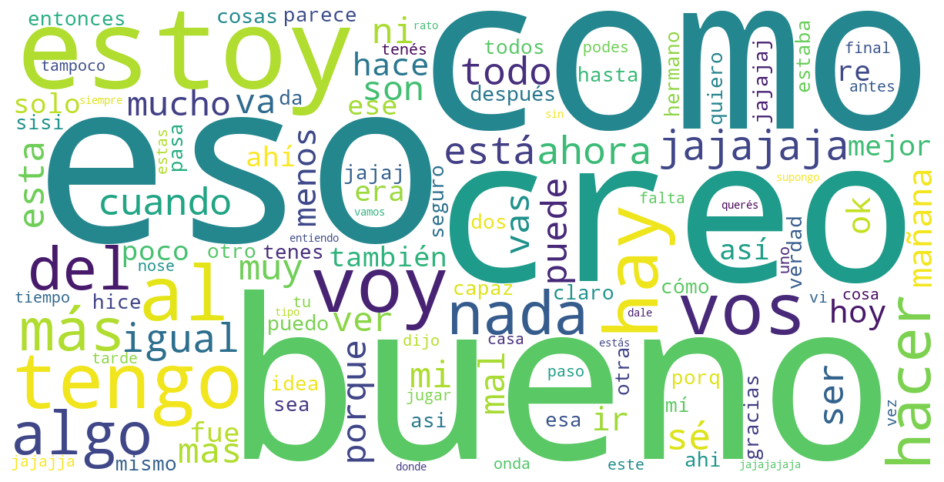

In [16]:
import re
from collections import Counter
import pandas as pd

# Optional: word cloud visualization
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except Exception:
    WORDCLOUD_AVAILABLE = False

import matplotlib.pyplot as plt

# -----------------------------
# Safety checks
# -----------------------------
assert "data" in globals() and isinstance(data, pd.DataFrame) and "text" in data.columns, \
    "❌ data (dataset final) no existe o no tiene columna 'text'"

# -----------------------------
# Regex & token helpers
# -----------------------------
TAG_RE = re.compile(r"<\|.*?\|>")
WORD_RE = re.compile(r"[a-záéíóúñü0-9']+", flags=re.IGNORECASE)

SYSTEM_BLOCK_RE = re.compile(r"<\|im_start\|>system.*?<\|im_start\|>", re.DOTALL | re.IGNORECASE)
THINK_RE = re.compile(r"<think>.*?</think>", re.DOTALL | re.IGNORECASE)
IM_TAG_RE = re.compile(r"<\|im_(start|end)\|>", re.IGNORECASE)
MSG_SEP_RE = re.compile(r"<\|msg_sep\|>", re.IGNORECASE)
METADATA_RE = re.compile(r"##\s*metadata.*?(?=<\|im_start\|>|$)", re.DOTALL | re.IGNORECASE)

# -----------------------------
# Dynamic stopwords
# -----------------------------
AUTHOR_STOP_WORDS = set()
if "target_author" in globals() and isinstance(target_author, str) and target_author.strip():
    AUTHOR_STOP_WORDS = {
        w for w in re.findall(r"[a-záéíóúñü]+", target_author.lower())
        if len(w) >= 2
    }

SYSTEM_PROMPT_WORDS = set()
if "bot_name" in globals() and "target_author" in globals():
    sys_prompt = (
        f"Eres {bot_name}, un bot de {target_author}, que se encarga de mantener "
        f"conversaciones casuales. Respondes con la misma personalidad que {target_author} "
        f"tiene en los chats de WhatsApp."
    )
    SYSTEM_PROMPT_WORDS = {
        w for w in re.findall(r"[a-záéíóúñü]+", sys_prompt.lower())
        if len(w) >= 2
    }

STOP_WORDS_EXTRA = {
    "user", "assistant", "system",
    "metadata", "knowledge", "cutoff", "date", "today",
    "reasoning", "mode", "custom", "instructions",
    "im_start", "im_end", "think", "msg_sep", "no_think",
    "end", "start"
}.union(AUTHOR_STOP_WORDS).union(SYSTEM_PROMPT_WORDS)

EN_TIME_WORDS = {
    "january","february","march","april","may","june","july","august",
    "september","october","november","december",
    "monday","tuesday","wednesday","thursday","friday","saturday","sunday"
}
STOP_WORDS_EXTRA |= EN_TIME_WORDS

SPANISH_STOPWORDS = {
    "el","la","los","las","un","una","unos","unas",
    "yo","me","te","se","lo","le","nos","les",
    "de","que","y","o","pero","si","no","es","en","con","por","para",
    "ya","bien","eh","ah","oh","xd","jaja","jajaja",
    "q","k","tmb","tb","pa","pq","xq"
}

# -----------------------------
# Normalization (stats only)
# -----------------------------
def normalize_for_stats(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = SYSTEM_BLOCK_RE.sub(" ", text)
    text = METADATA_RE.sub(" ", text)
    text = THINK_RE.sub(" ", text)
    text = IM_TAG_RE.sub(" ", text)
    text = MSG_SEP_RE.sub(" ", text)
    text = TAG_RE.sub(" ", text)
    text = text.lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def extract_words_raw(text: str):
    words = WORD_RE.findall(normalize_for_stats(text))
    return [w.lower() for w in words if w.lower() not in STOP_WORDS_EXTRA and len(w) >= 2]

def extract_words_informative(text: str):
    return [w for w in extract_words_raw(text) if w not in SPANISH_STOPWORDS]

# -----------------------------
# Dataset-level statistics
# -----------------------------
texts = data["text"].astype(str).tolist()
texts = [t for t in texts if t.strip()]
n = len(texts)

char_lengths = [len(t) for t in texts]
word_lengths = [len(extract_words_raw(t)) for t in texts]

vocab_raw = Counter()
vocab_info = Counter()
for t in texts:
    vocab_raw.update(extract_words_raw(t))
    vocab_info.update(extract_words_informative(t))

stats = {
    "samples": n,
    "exact_duplicates": int(data["text"].duplicated().sum()),
    "chars_avg": sum(char_lengths) / max(1, n),
    "words_avg": sum(word_lengths) / max(1, n),
    "words_p95": float(pd.Series(word_lengths).quantile(0.95)) if n else 0.0,
    "unique_words": int(len(vocab_raw)),
    "vocab_richness_pct": 100.0 * len(vocab_raw) / max(1, sum(vocab_raw.values())),
}

if "tokenizer" in globals() and tokenizer is not None:
    try:
        token_lengths = [len(tokenizer(t, add_special_tokens=False).input_ids) for t in texts]
        stats["tokens_avg"] = sum(token_lengths) / max(1, n)
        stats["tokens_p95"] = float(pd.Series(token_lengths).quantile(0.95))
    except Exception:
        pass

print("\n📊 Estadísticas del dataset final (SmolLM3)")
display(pd.DataFrame([stats]))

# -----------------------------
# Top words: con / sin muletillas
# -----------------------------
TOP_K = 20

top_raw = pd.DataFrame(vocab_raw.most_common(TOP_K), columns=["palabra", "frecuencia"])
top_info = pd.DataFrame(vocab_info.most_common(TOP_K), columns=["palabra", "frecuencia"])

max_len = max(len(top_raw), len(top_info))
top_raw = top_raw.reindex(range(max_len))
top_info = top_info.reindex(range(max_len))

spacer = pd.DataFrame({"": [""] * max_len})
spacer.columns = pd.MultiIndex.from_product([[""], [""]])

top_raw.columns = pd.MultiIndex.from_product([["Con muletillas"], top_raw.columns])
top_info.columns = pd.MultiIndex.from_product([["Sin muletillas"], top_info.columns])

print(f"\n🔝 Top {TOP_K} palabras del dataset final")
display(pd.concat([top_raw, spacer, top_info], axis=1))

# -----------------------------
# Word cloud (informative)
# -----------------------------
if WORDCLOUD_AVAILABLE and vocab_info:
    print("\n🖼️ Nube de palabras (dataset final, sin muletillas)")
    wc = WordCloud(
        width=1200,
        height=600,
        background_color="white",
        max_words=120,
        collocations=False
    ).generate_from_frequencies(dict(vocab_info))

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
elif not WORDCLOUD_AVAILABLE:
    print("\nℹ️ WordCloud no disponible (pip install wordcloud)")


## Evaluación cuantitativa y reporte final

Calculamos métricas cuantitativas sobre el conjunto de validación para comparar el modelo base y el modelo fine-tuneado. Se reportan la cross-entropy promedio y la perplexity aproximada, junto con una visualización comparativa que resume el impacto del fine-tuning.


Evaluando modelo base...
Midiendo métricas en 100 ejemplos...


100%|██████████| 100/100 [00:03<00:00, 31.49it/s]



Evaluando modelo fine-tuneado...
Midiendo métricas en 100 ejemplos...


100%|██████████| 100/100 [00:04<00:00, 22.95it/s]
/tmp/ipykernel_46/2218530845.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(



RESULTADOS DE EVALUACIÓN
----------------------------------------
Base model   → Cross-Entropy: 3.433 | Perplexity: 30.98
Fine-tuned   → Cross-Entropy: 0.905 | Perplexity: 2.47
Mejora relativa en Perplexity: 92.02%
Nota: una menor perplexity indica una mejor modelización del estilo conversacional.


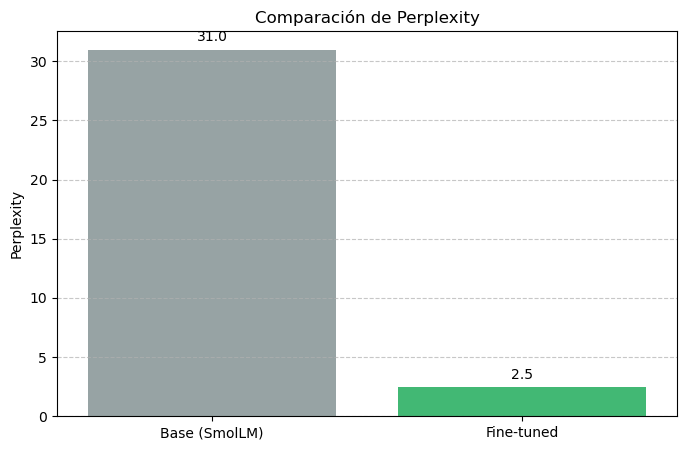

In [15]:
def evaluate_model(model, data_iterable, tokenizer, max_batches=100):
    """
    Computes cross-entropy loss and perplexity for a causal language model.
    Expects an iterable with a 'text' field containing pre-formatted chat samples.
    """
    model.eval()
    losses = []

    print(f"Midiendo métricas en {max_batches} ejemplos...")

    with torch.no_grad():
        for i, example in enumerate(tqdm(data_iterable, total=max_batches)):
            if i >= max_batches:
                break

            # Extract pre-formatted chat text
            text = example["text"]

            # Tokenize on the fly
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=1024
            ).to("cuda")

            # Causal LM loss (labels = input_ids)
            outputs = model(**inputs, labels=inputs["input_ids"])
            losses.append(outputs.loss.item())

    if not losses:
        return {"cross_entropy": 0.0, "perplexity": 0.0}

    avg_loss = sum(losses) / len(losses)
    try:
        perplexity = math.exp(avg_loss)
    except OverflowError:
        perplexity = float("inf")

    return {"cross_entropy": avg_loss, "perplexity": perplexity}


# --- VALIDATION DATA SELECTION ---
# Prefer an explicit validation split if available
if isinstance(dataset, dict) and "test" in dataset:
    eval_data = dataset["test"]
else:
    # Fallback: evaluate on a small subset of the dataset
    eval_data = dataset.select(range(min(50, len(dataset))))

# --- EVALUATION RUN ---

print("\nEvaluando modelo base...")
metrics_base = evaluate_model(base_model, eval_data, tokenizer)

print("\nEvaluando modelo fine-tuneado...")
metrics_fine = evaluate_model(fine_model, eval_data, tokenizer)


# --- REPORTING ---
print("\nRESULTADOS DE EVALUACIÓN")
print("-" * 40)
print(
    f"Base model   → Cross-Entropy: {metrics_base['cross_entropy']:.3f} | "
    f"Perplexity: {metrics_base['perplexity']:.2f}"
)
print(
    f"Fine-tuned   → Cross-Entropy: {metrics_fine['cross_entropy']:.3f} | "
    f"Perplexity: {metrics_fine['perplexity']:.2f}"
)

# Relative improvement
if metrics_base["perplexity"] > 0:
    improvement = (
        (metrics_base["perplexity"] - metrics_fine["perplexity"])
        / metrics_base["perplexity"]
        * 100
    )
else:
    improvement = 0.0

print(f"Mejora relativa en Perplexity: {improvement:.2f}%")
print("Nota: una menor perplexity indica una mejor modelización del estilo conversacional.")

# --- Visualization ---
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    x=["Base (SmolLM)", "Fine-tuned"],
    y=[metrics_base["perplexity"], metrics_fine["perplexity"]],
    palette=["#95a5a6", "#2ecc71"]
)

# Annotate bar values
for p in barplot.patches:
    barplot.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.title("Comparación de Perplexity")
plt.ylabel("Perplexity")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
